# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.45KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

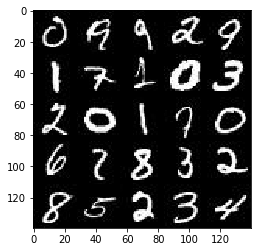

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

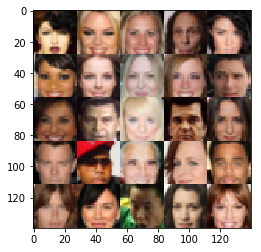

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="Input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="Input_z")
    learning_rate = tf.placeholder(tf.float32)

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #drop = 0.5
    with tf.variable_scope("discriminator", reuse=reuse):
        #Input to discriminator is 28x28xChannels
        disc = tf.layers.conv2d(images, 128, 5, strides=1, padding='same')
        disc = tf.maximum(alpha*disc, disc)
        
        #shape=28x28x64
        disc = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        disc = tf.layers.batch_normalization(disc, training=True)
        #disc = tf.nn.dropout(disc, drop)
        disc = tf.maximum(alpha*disc, disc)
        
        #shape=14x14x128
        disc = tf.layers.conv2d(disc, 32, 5, strides=2, padding='same')
        disc = tf.layers.batch_normalization(disc, training=True)
        #disc = tf.nn.dropout(disc, drop)
        disc = tf.maximum(alpha*disc, disc)
        
        #Flattening
        flat = tf.reshape(disc, (-1, 4*4*32))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #drop = 0.5
    reuse = True if is_train==False else False
    with tf.variable_scope("generator", reuse=reuse):
        #gen = tf.nn.dropout(tf.layers.dense(z, 7*7*512), drop)
        gen = tf.layers.dense(z, 7*7*128)
        gen = tf.reshape(gen, (-1,7,7,128))
        gen = tf.layers.batch_normalization(gen, training=is_train)
        #gen = tf.nn.dropout(gen, drop)
        gen = tf.maximum(alpha*gen, gen)
        #Input is 7x7x512
        gen = tf.layers.conv2d_transpose(gen, 64, 5, strides=2, padding='same')
        gen = tf.layers.batch_normalization(gen, training=is_train)
        #gen = tf.nn.dropout(gen, drop)
        gen = tf.maximum(alpha*gen, gen)
        #Now 14x14x256
        gen = tf.layers.conv2d_transpose(gen, 32, 5, strides=2, padding='same')
        gen = tf.layers.batch_normalization(gen, training=is_train)
        #gen = tf.nn.dropout(gen, drop)
        gen = tf.maximum(alpha*gen, gen)
        #Now 28x28x128        
        
        logits = tf.layers.conv2d_transpose(gen, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_model_real)))
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)))
    
    disc_total_loss = disc_loss_real + disc_loss_fake
    
    return (disc_total_loss, gen_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
    return (disc_train_opt, gen_train_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    channels = 3 if data_image_mode == 'RGB' else 1
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0    
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                #For printing and sampling purposes
                step+=1
                #Random noise for z
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Optimizers
                #Discriminator
                _, train_loss_d = sess.run([d_opt,d_loss], feed_dict={input_real : batch_images,
                                               input_z : batch_z,
                                               lr : learning_rate})
                #Generator
                _, train_loss_g = sess.run([g_opt,g_loss], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})
                _ = sess.run([g_opt], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})
                if(step%25 == 0):
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if(step%100 == 0):
                    show_generator_output(sess, 10, input_z, channels, data_image_mode)                                                                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.9918
Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 1.0447
Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.8464
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.7769


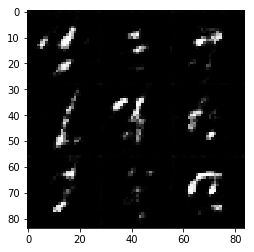

Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.8469
Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.2780... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 1.3124... Generator Loss: 0.8252


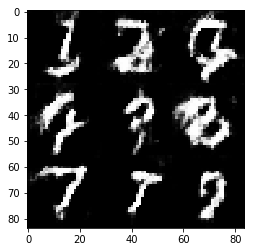

Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 0.7967
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.7703
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 0.7756
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.7856


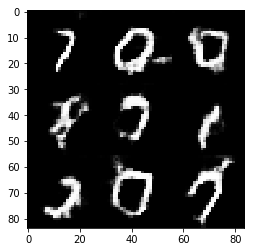

Epoch 1/2... Discriminator Loss: 1.3318... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.7340
Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 0.7798


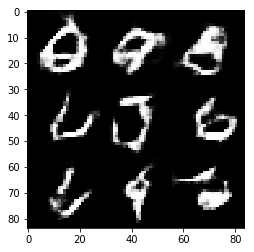

Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.7664


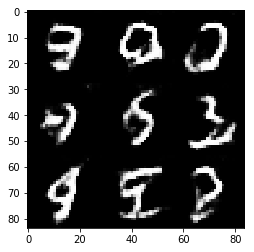

Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 0.7928
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.7588


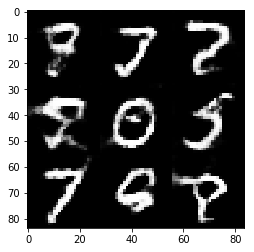

Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.7774
Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 0.7835


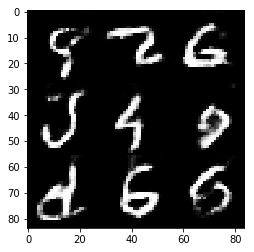

Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 1.3412... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 0.8499


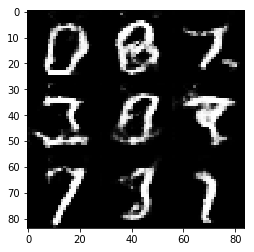

Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 0.7405
Epoch 1/2... Discriminator Loss: 1.2954... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.7697


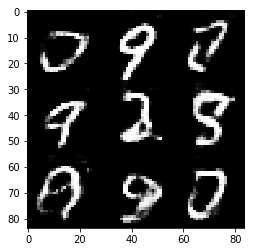

Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.8304
Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.8616
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.8393


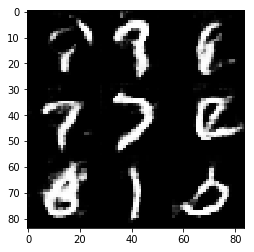

Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.8339
Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 0.8700
Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 0.7859


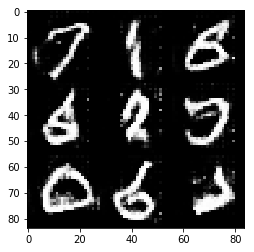

Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.7769
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.8453
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.8640
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 0.7858


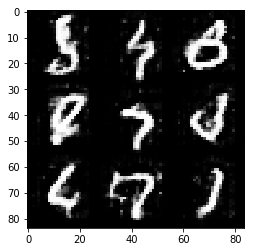

Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.3354... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 0.7863


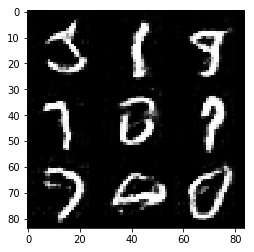

Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.8097
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.8748


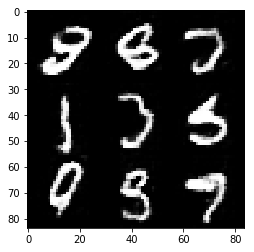

Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.7782


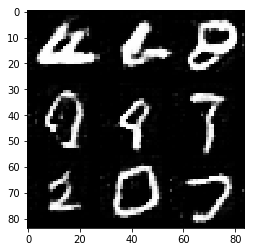

Epoch 1/2... Discriminator Loss: 1.3512... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.3325... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.8075


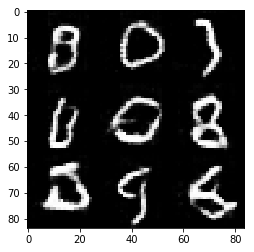

Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.7944
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 0.7677


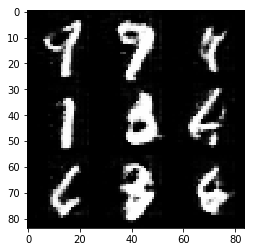

Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.8210
Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 1.3512... Generator Loss: 0.7715


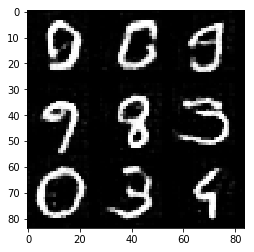

Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.7622
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.8426
Epoch 1/2... Discriminator Loss: 1.2783... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.8008


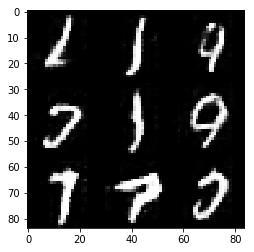

Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.7896
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.7996
Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.7870
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.7932


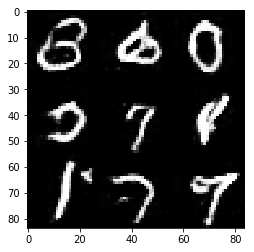

Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.8229


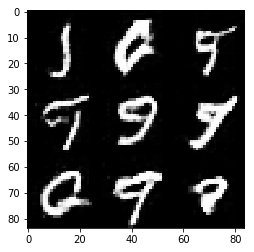

Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.7550
Epoch 2/2... Discriminator Loss: 1.3557... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.7963
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.7847


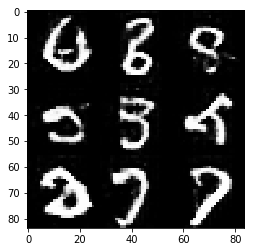

Epoch 2/2... Discriminator Loss: 1.2922... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.7590


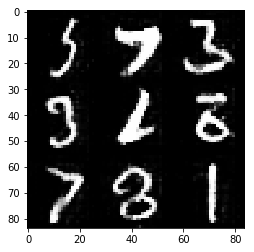

Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.7685
Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.7670


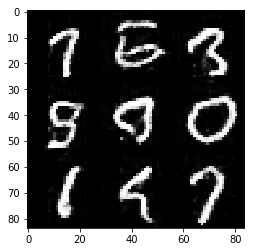

Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 0.7913
Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 1.3571... Generator Loss: 0.7571


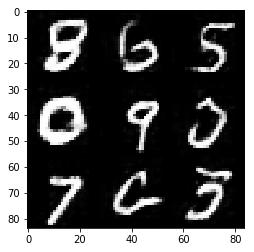

Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 0.8121
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.7842


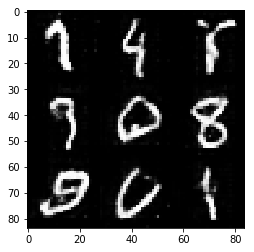

Epoch 2/2... Discriminator Loss: 1.3194... Generator Loss: 0.8169
Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.7700
Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 0.7829


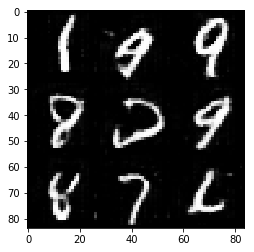

Epoch 2/2... Discriminator Loss: 1.3474... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 1.2933... Generator Loss: 0.8198


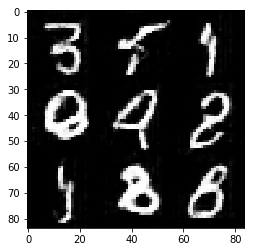

Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 1.3324... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.7718
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.8126


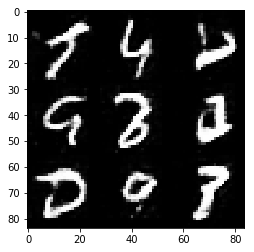

Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.8097
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.8915


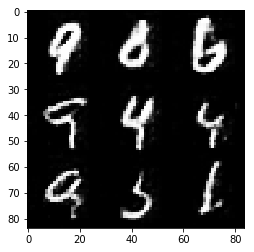

Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.8447
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.7840
Epoch 2/2... Discriminator Loss: 1.2528... Generator Loss: 0.8948
Epoch 2/2... Discriminator Loss: 1.3361... Generator Loss: 0.8037


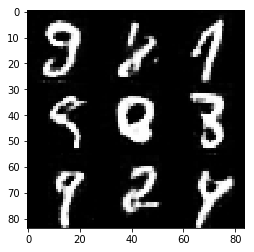

Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.8485
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.8257
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.8016


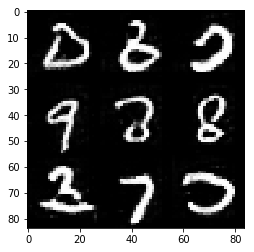

Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.7822
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 0.8473
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.7627


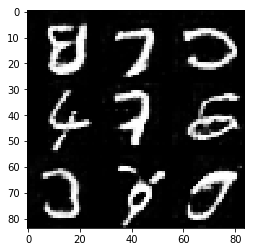

Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 0.7879
Epoch 2/2... Discriminator Loss: 1.2749... Generator Loss: 0.8228
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 0.8389
Epoch 2/2... Discriminator Loss: 1.2941... Generator Loss: 0.8504


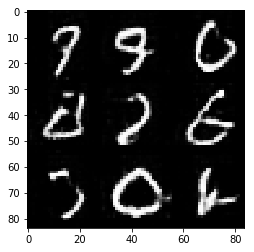

Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 0.8523
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.8123
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.8211


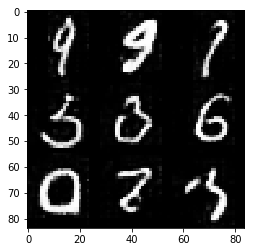

Epoch 2/2... Discriminator Loss: 1.3032... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.2898... Generator Loss: 0.8135
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.9022
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.8309


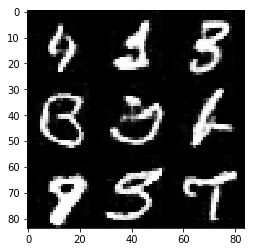

Epoch 2/2... Discriminator Loss: 1.3361... Generator Loss: 0.8550
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.8360


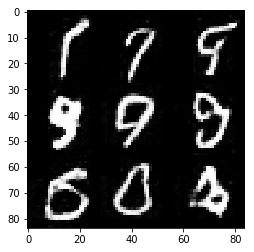

Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.8925
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.8642


In [13]:
batch_size = 32
z_dim = 150
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 1.4131... Generator Loss: 0.9069
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 1.0411
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 1.1438


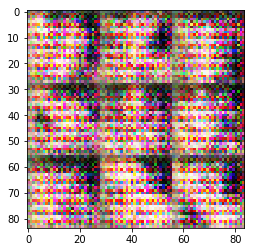

Epoch 1/2... Discriminator Loss: 1.1709... Generator Loss: 1.1762
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.9354
Epoch 1/2... Discriminator Loss: 1.4042... Generator Loss: 0.8897
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.7699


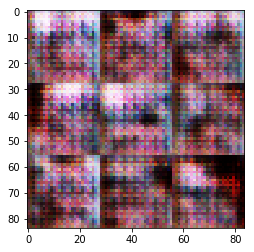

Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.7735


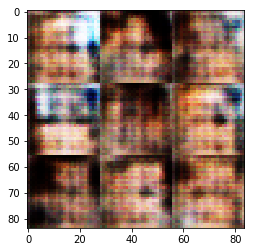

Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.7736
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.7398
Epoch 1/2... Discriminator Loss: 1.4510... Generator Loss: 0.7137


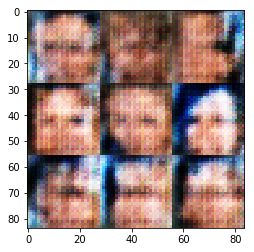

Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.7318
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.7146
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.7135


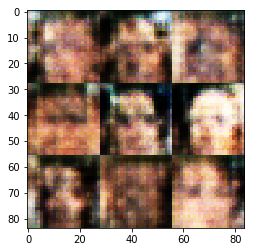

Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.4279... Generator Loss: 0.7184
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.7082
Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.7263


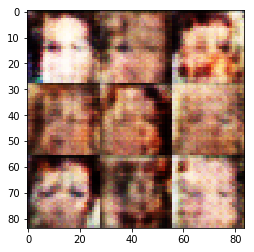

Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.7167
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.4069... Generator Loss: 0.7131
Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.7273


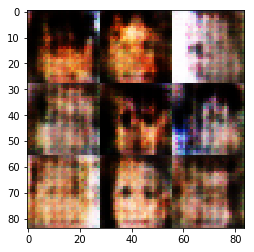

Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.7009
Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.7209


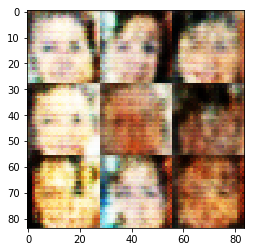

Epoch 1/2... Discriminator Loss: 1.4145... Generator Loss: 0.6896
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.7112


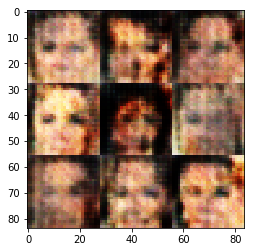

Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.7022
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.7135


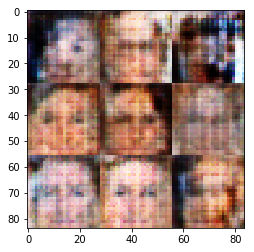

Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.7065
Epoch 1/2... Discriminator Loss: 1.4066... Generator Loss: 0.7102
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.7118
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.6925


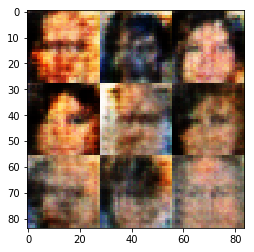

Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 0.6929
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.7218


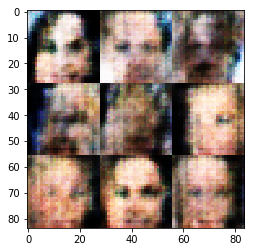

Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.7144
Epoch 1/2... Discriminator Loss: 1.4084... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.7233


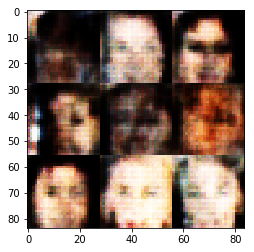

Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.6786
Epoch 1/2... Discriminator Loss: 1.4015... Generator Loss: 0.7037


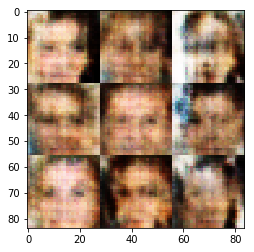

Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.6908


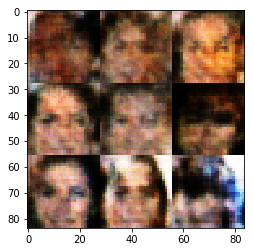

Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.7067
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.7004
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.6992
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.7019


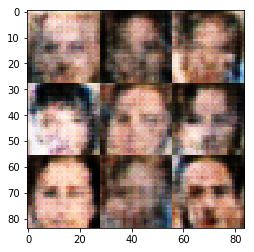

Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 0.7057
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.7228
Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.6983
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.7038


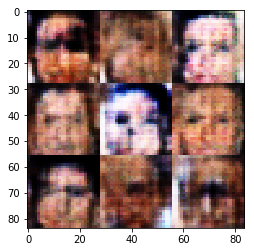

Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.7063
Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.7044


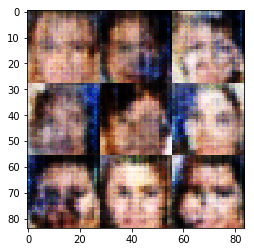

Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.6956
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.7000
Epoch 1/2... Discriminator Loss: 1.3903... Generator Loss: 0.7047
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.7003


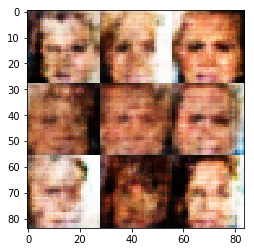

Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.7039
Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.6993


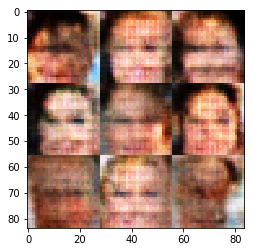

Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 0.7257
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.7019
Epoch 1/2... Discriminator Loss: 1.3978... Generator Loss: 0.7122
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.7003


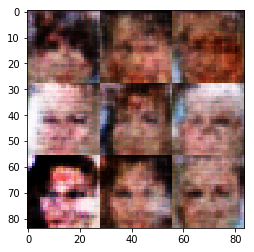

Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.7114
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.7166


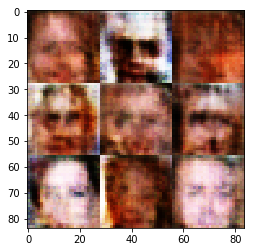

Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 0.7059
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.7030


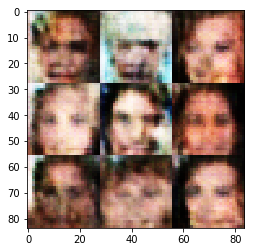

Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.7028
Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.6975
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.7121
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.6967


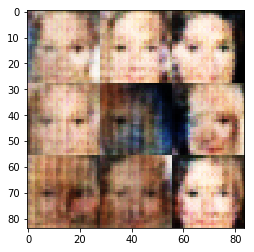

Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.7203
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.6988


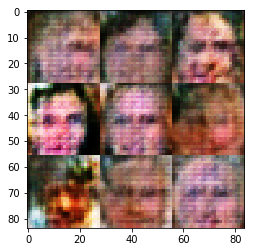

Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.6940
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 0.7089


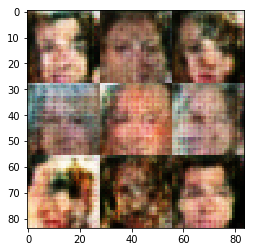

Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.6936
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.7080
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.7080


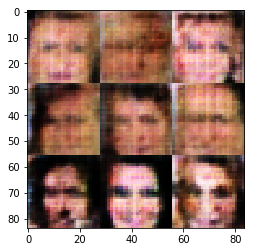

Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.7217
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.6977
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.6876


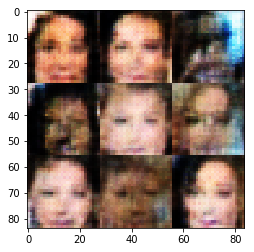

Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 0.7042
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.6981


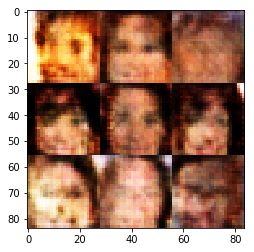

Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.6990
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.6998
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.6984


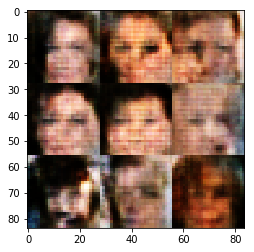

Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.7131


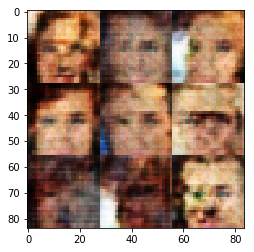

Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.6950
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.7037
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.6897
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.7051


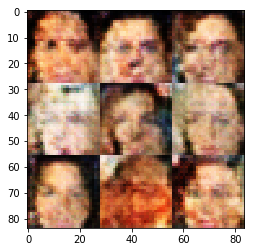

Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.7009


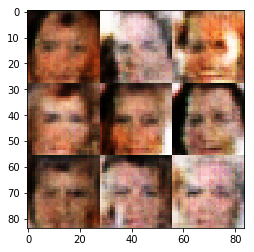

Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.6991
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.6941
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.7015


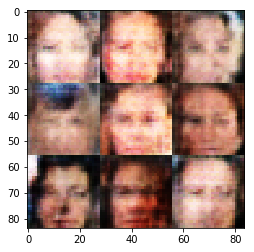

Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.6954


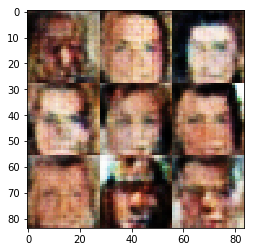

Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.6987
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.7024
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.6970


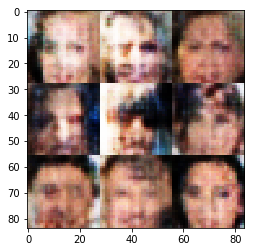

Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.6990
Epoch 1/2... Discriminator Loss: 1.3903... Generator Loss: 0.7068


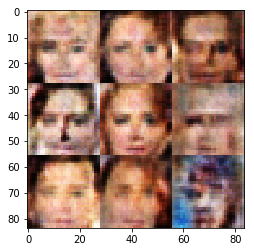

Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.7150
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 0.7029
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.7096


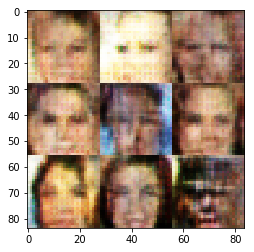

Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 0.7094
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.7032


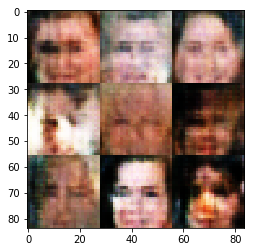

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.7047
Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 0.7069


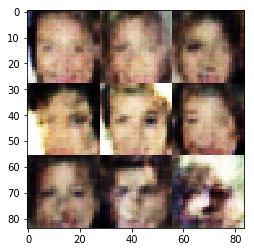

Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.7045
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.6999


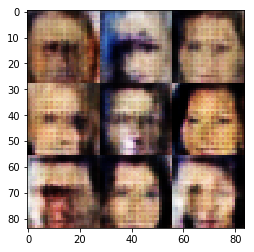

Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.7022
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.7228
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.6975


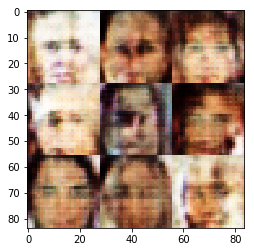

Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.7077
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.7082
Epoch 1/2... Discriminator Loss: 1.4024... Generator Loss: 0.6899


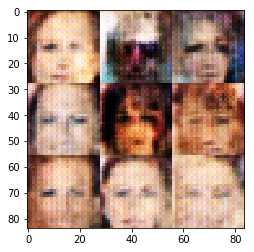

Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 0.7182
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.7040


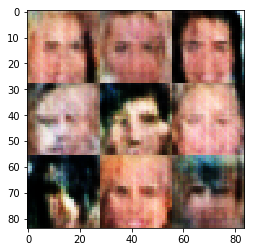

Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.7068
Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.6930
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.7049
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.7076


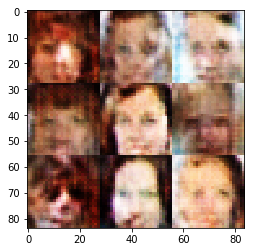

Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.7037
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.6968


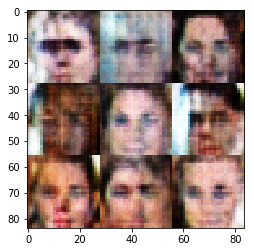

Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.7084
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.6970


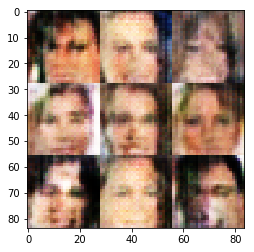

Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.7042
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.7115


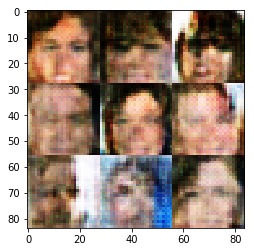

Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.6990
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.7072


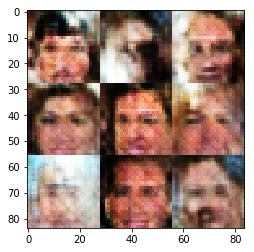

Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.6930
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.7077
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.7005


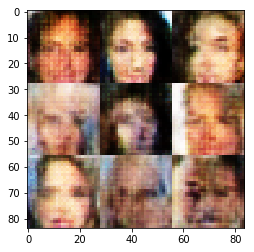

Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.6852
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.7041
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.6983


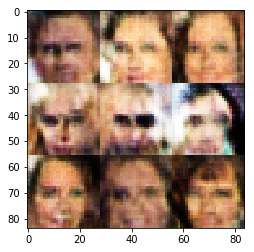

Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.6966
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.6977
Epoch 1/2... Discriminator Loss: 1.3896... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.6955


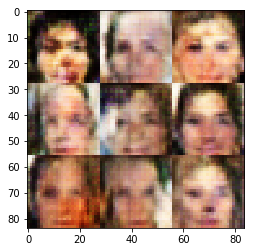

Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 1.3958... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.7065


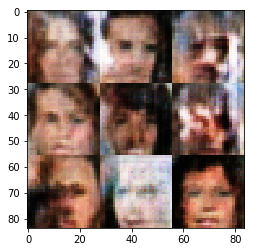

Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.3936... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.7046


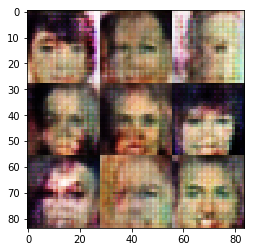

Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 0.7007
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.6993


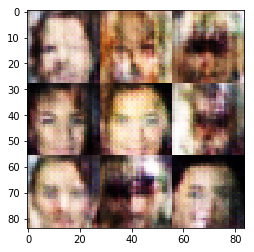

Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.7114
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.7084
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.6972


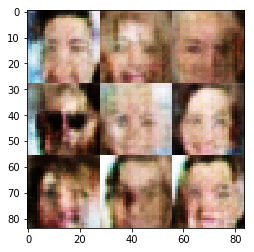

Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.7045
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.7030


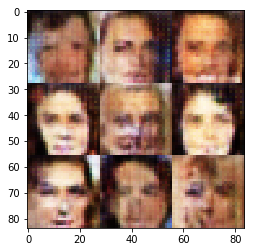

Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.7086
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.7053


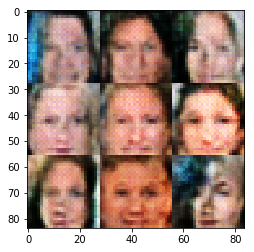

Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.6930
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.6879
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.7052


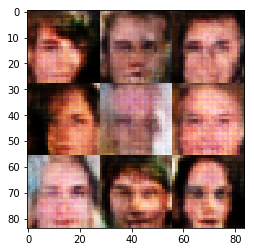

Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.6908
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.7030


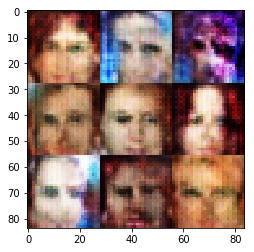

Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7269
Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.6879
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.7004


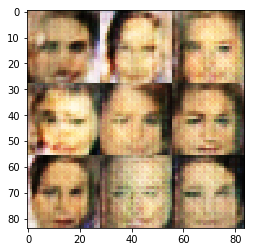

Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.7002
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.3896... Generator Loss: 0.7020


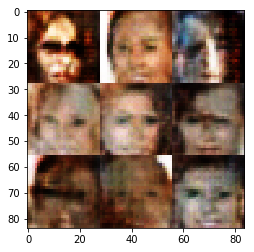

Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.7107
Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.6977
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.6896


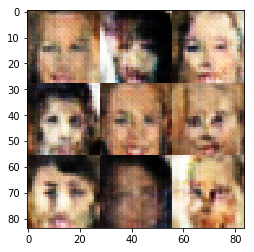

Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.6848
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.7192
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.7096


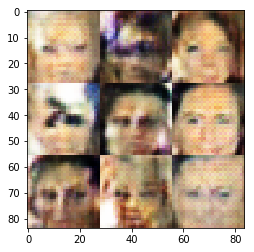

Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.6948
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.6961


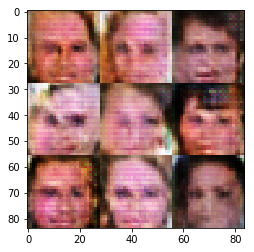

Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.6935
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.6893


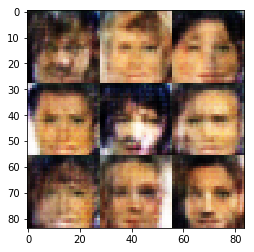

Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.6898
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.6908


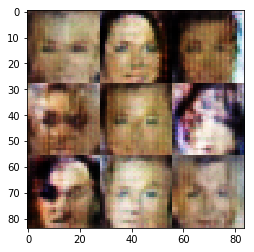

Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.6810
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.7024


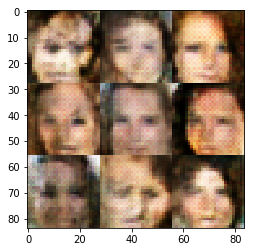

Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.7067
Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.6916


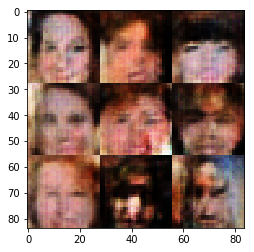

Epoch 2/2... Discriminator Loss: 1.4024... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.6973


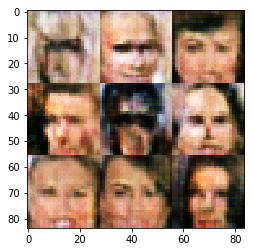

Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.7039
Epoch 2/2... Discriminator Loss: 1.3821... Generator Loss: 0.7073
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.7075


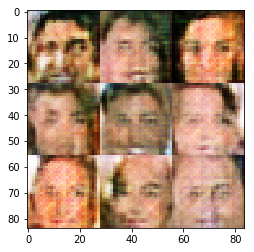

Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.7043


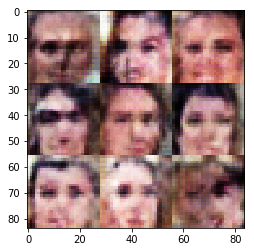

Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.7110
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.6999


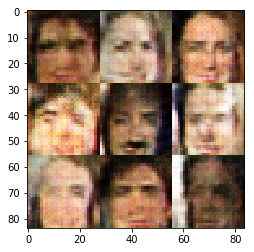

Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.6938
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.7028


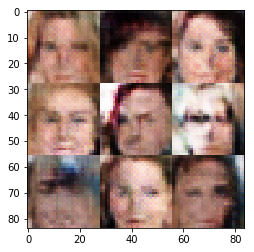

Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.6900
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.7096
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.7014
Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.7029


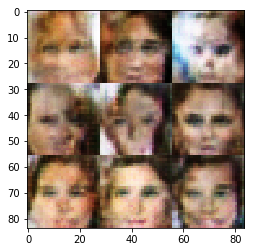

Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.6948


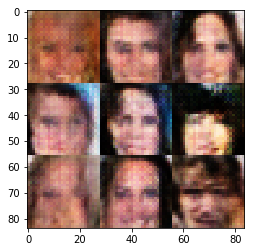

Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.7097
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.7022


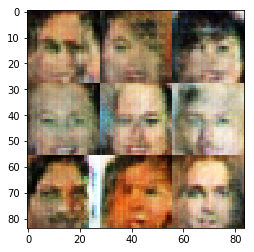

Epoch 2/2... Discriminator Loss: 1.3903... Generator Loss: 0.7058
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.7059
Epoch 2/2... Discriminator Loss: 1.3887... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3874... Generator Loss: 0.7094


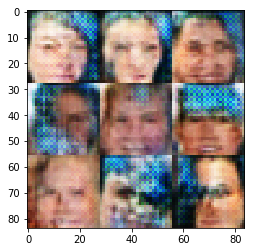

Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7010
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.6934


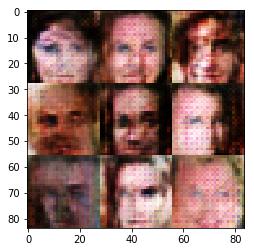

Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.6920


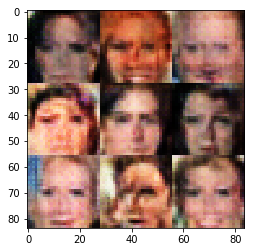

Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.7107
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.7037


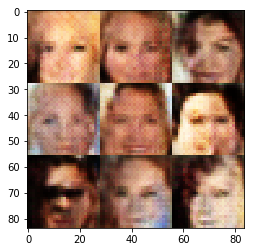

Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.7066
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.7066


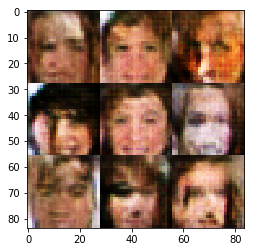

Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.7010
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.6928


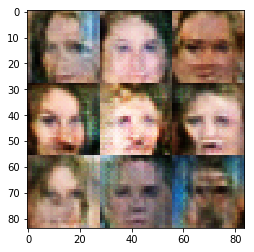

Epoch 2/2... Discriminator Loss: 1.3948... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.6935


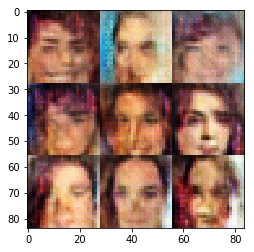

Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.7010
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.7016


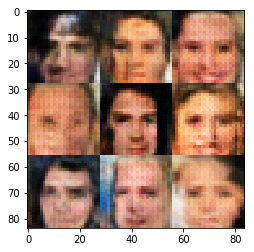

Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.7018
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.7016
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.7088


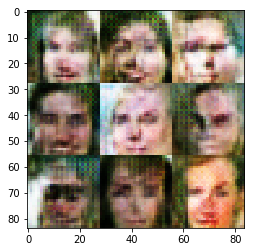

Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.6948
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.7007
Epoch 2/2... Discriminator Loss: 1.3867... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.6998


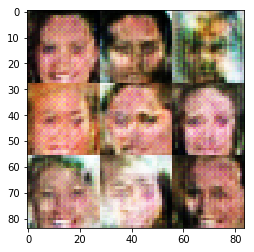

Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.7017
Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.7035
Epoch 2/2... Discriminator Loss: 1.3850... Generator Loss: 0.6936
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.6972


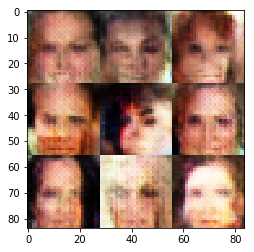

Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.6968
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.6975
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.6908


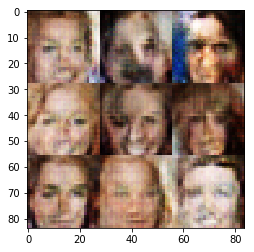

Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.6989
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.6993
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.3887... Generator Loss: 0.6967


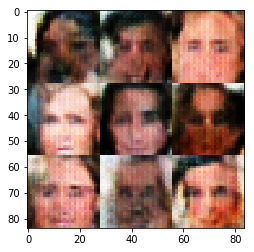

Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.7009
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.6911


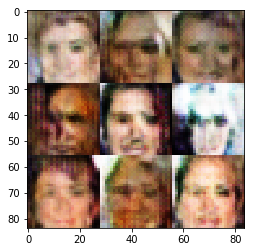

Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.6963
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.6981
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.6896


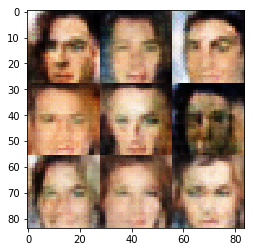

Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.3850... Generator Loss: 0.6972
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.6921


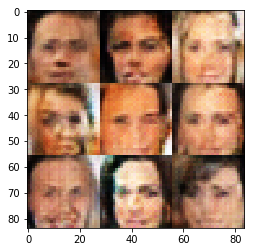

Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.6968
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.3878... Generator Loss: 0.6999


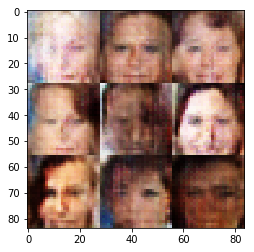

Epoch 2/2... Discriminator Loss: 1.3875... Generator Loss: 0.7040
Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.6944
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.6980


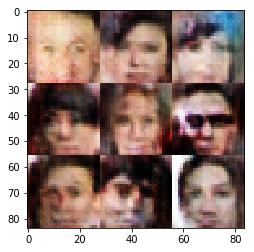

Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6993
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.7013
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.6971


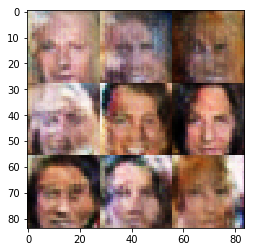

Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.3925... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 0.6939


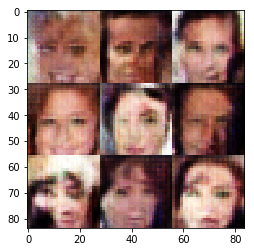

Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.3887... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.7009


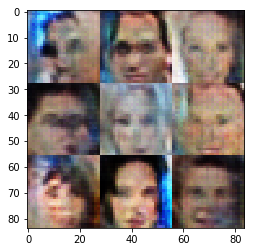

Epoch 2/2... Discriminator Loss: 1.3835... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.6963
Epoch 2/2... Discriminator Loss: 1.3835... Generator Loss: 0.7052
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.7038


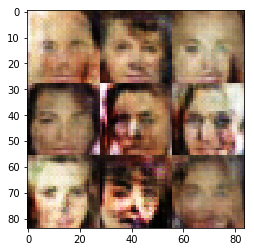

Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 0.6968
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.7048


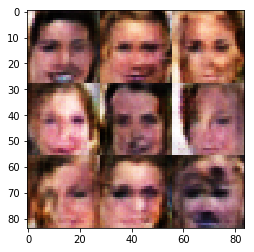

Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.6975
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.3903... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.6952


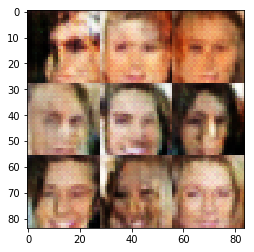

Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 0.6948
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.6950


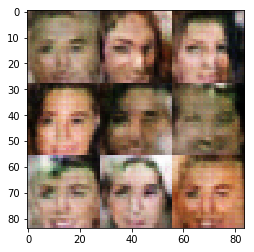

Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.7059
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.6904
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.7052
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.7005


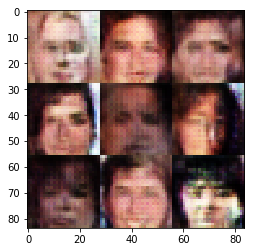

Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.6994


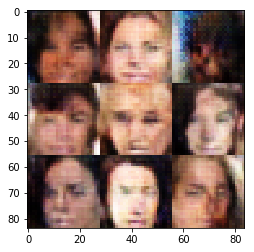

Epoch 2/2... Discriminator Loss: 1.3842... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.6992


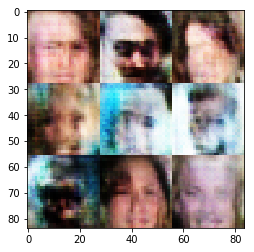

Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.3835... Generator Loss: 0.7083
Epoch 2/2... Discriminator Loss: 1.3850... Generator Loss: 0.7006


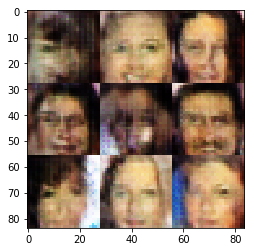

Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.7040
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.7031


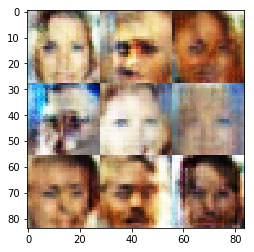

Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 0.6959


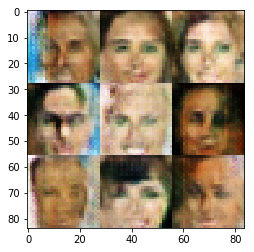

Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.6959


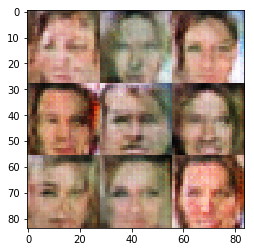

Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.6981
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.6991
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.7018


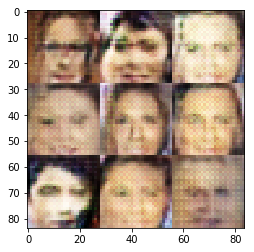

Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.3867... Generator Loss: 0.6927
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.6962


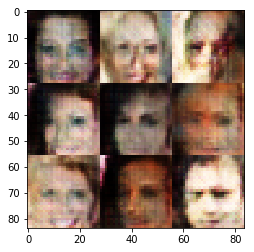

Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 0.6910
Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.7013
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.7039


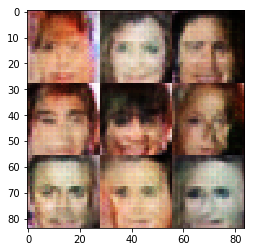

Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.6975
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.6868


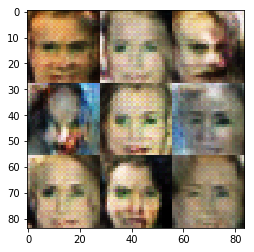

Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.7013


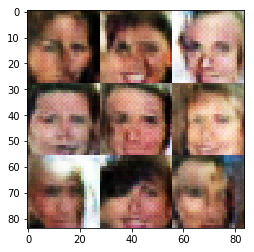

Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.7061
Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.7039
Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.7040


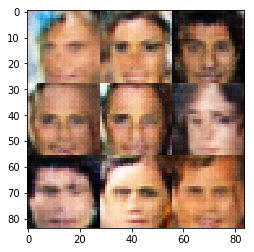

Epoch 2/2... Discriminator Loss: 1.3837... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.6982
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.7066


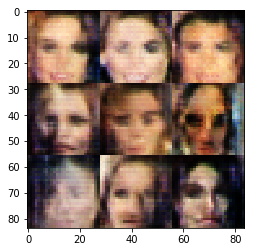

Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.7017
Epoch 2/2... Discriminator Loss: 1.3834... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.6877


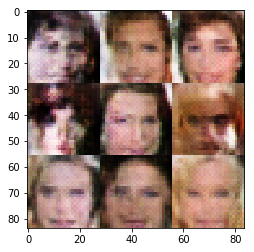

Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.6942
Epoch 2/2... Discriminator Loss: 1.3895... Generator Loss: 0.6952
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.6935


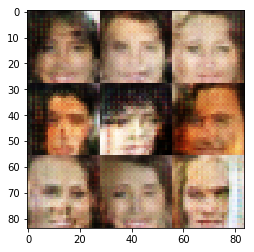

Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.6938
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.6991
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.6936
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.7025


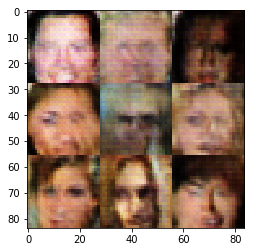

Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.3867... Generator Loss: 0.6952
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.3847... Generator Loss: 0.7029


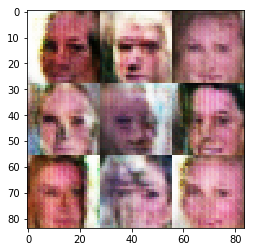

Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.6970
Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.7065
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.7039


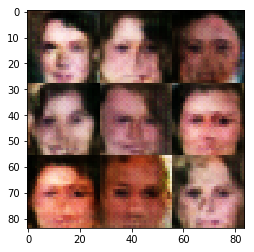

Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.7037
Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.6896
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.6992
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.7012


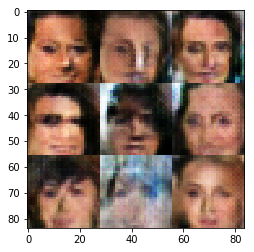

Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.7010
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.6986


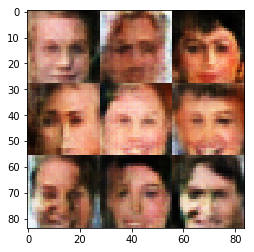

Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.7023


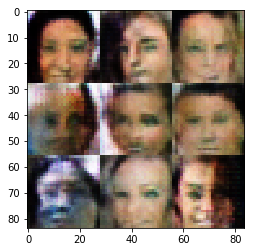

Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.7007
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.3834... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.6939


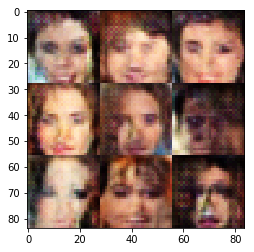

Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.7073
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.7049
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.6919


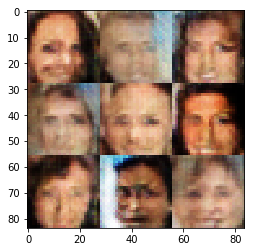

Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.6989
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.7014


In [15]:
batch_size = 32
z_dim = 150
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.